In [1]:
from utils import *
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import matplotlib as mpl
from sklearn.preprocessing import scale
from scipy import optimize

In [3]:
def run1(depth):
    print(f"Computing vars depth={depth}")
    k1 = Matern(nu=0.5)
    k2 = NTK(depth=depth, c=2.0)

    if depth < 10:
        ellmax = 10
    elif depth >= 10 and depth < 30:
        ellmax = 5
    elif depth >= 30:
        ellmax = 1.5

    bias = np.linspace(0, 5, 50)
    lengthscale = np.linspace(0.0001, ellmax, 50)

    candidates = []
    for coor in range(0, 100):
        data = {
            'xy': [], 
            # 'params': [], 
            'var': [], 
            # 'vals': []
        }
        x1 = normalize(np.random.randint(0, 100, 3).reshape(1,-1))
        y1 = normalize(np.random.randint(0, 100, 3).reshape(1,-1))

        x2 = normalize(np.random.randint(0, 100, 3).reshape(1,-1))
        y2 = normalize(np.random.randint(0, 100, 3).reshape(1,-1))

        data['xy'].append(((x1, y1), (x2, y2)))

        for b in bias:
            k2.bias = b
            ntk_val_1 = k2(x1,y1)
            ntk_val_2 = k2(x2,y2)
            for ell in lengthscale:
                k1.length_scale = ell
                # data['params'].append((k2.bias, k1.length_scale))
                lpk_val_1 = k1(x1,y1)
                lpk_val_2 = k1(x2,y2)
                val1 = (lpk_val_1-ntk_val_1).squeeze()
                val2 = (lpk_val_2-ntk_val_2).squeeze()
                # data['vals'].append((val1, val2))
                data['var'].append(
                    np.var([val1, val2])
                )

        candidates.append(data)

    candidates.sort(key=lambda item : np.min(item.get('var')))
    print(f"Finished vars depth={depth}")

    return candidates

def run2(depth):
    if depth < 10:
        ellmax = 10
    elif depth >= 10 and depth < 30:
        ellmax = 5
    elif depth >= 30:
        ellmax = 1.5

    bias = np.linspace(0, 5, 100)
    lengthscale = np.linspace(0.0001, ellmax, 100)

    print(f"Computing rand depth={depth}")
    k1 = Matern(nu=0.5)
    k2 = NTK(depth=depth, c=2.0)

    x = normalize(np.random.randint(0, 100, 3).reshape(1,-1))
    y = normalize(np.random.randint(0, 100, 3).reshape(1,-1))

    vals = []
    for b in bias:
        k2.bias = b
        ntk_val = k2(x,y)
        for ell in lengthscale:
            k1.length_scale = ell
            lpk_val = k1(x,y)
            vals.append((lpk_val-ntk_val).squeeze())

    xy = np.array(vals).reshape(-1,500)
    print(f"Finished rand depth={depth}")
    return xy, x, y


with Pool(3) as p:
    # xvals_rand1 = p.map(run2, (3, 25, 100))
    xvals = p.map(run1, (3, 25, 100))


Computing vars depth=100Computing vars depth=25Computing vars depth=3


Finished vars depth=3
Finished vars depth=25
Finished vars depth=100


In [43]:
# Depth - candidate -:- KEYS
# xy : empty : 1, 2
np.min(xvals[2][0].get('var'))
# xvals[3][0].get('xy')[0][1]

1.931356694408289e-14

In [19]:
NTK(depth=1)(np.array([1,0,0]).reshape(1,-1),np.array([-1,0,0]).reshape(1,-1))
# NTK(depth=3)(normalize(np.random.randint(0, 100, 3).reshape(1,-1)), normalize(np.random.randint(0, 100, 3).reshape(1,-1)))

array([[0.00495049]])

In [23]:
np.random.seed(18935240) 

x1, y1 = normalize(np.random.randint(0, 100, 3).reshape(1,-1)), normalize(`|LPK(x2,y2) - NTK(x2,y2)`np.random.randint(0, 100, 3).reshape(1,-1))
x2, y2 = normalize(np.random.randint(0, 100, 3).reshape(1,-1)), normalize(np.random.randint(0, 100, 3).reshape(1,-1))
xr, yr = normalize(np.random.randint(0, 100, 3).reshape(1,-1)), normalize(np.random.randint(0, 100, 3).reshape(1,-1))
print(x1)
print(y1)
print(x2)
print(y2)
print(xr)
print(yr)

[[0.8009002  0.47266241 0.36762632]]
[[0.70035337 0.08437992 0.70879136]]
[[0.04318335 0.99321709 0.10795838]]
[[0.50566869 0.20924222 0.83696886]]
[[0.4166215  0.90899237 0.01262489]]
[[0.61486267 0.67548293 0.40702176]]


In [31]:
def f(params, ntk, lpk):
    # x1, y1 = np.array([1,0,0]).reshape(1,-1), np.array([0,1,0]).reshape(1,-1)
    # x2, y2 = np.array([1,0,0]).reshape(1,-1), np.array([-1,0,0]).reshape(1,-1)

    ntk.bias = params[0]
    lpk.length_scale = params[1]

    ntk_val_1 = ntk(x1,y1)
    ntk_val_2 = ntk(x2,y2)

    lpk_val_1 = lpk(x1,y1)
    lpk_val_2 = lpk(x2,y2)

    metric = (
        np.var([np.abs(ntk_val_1 - lpk_val_1).squeeze(), np.abs(ntk_val_2 - lpk_val_2).squeeze()]) #+ 
        + np.abs(ntk_val_1 - lpk_val_1).squeeze()
        + np.abs(ntk_val_2 - lpk_val_2).squeeze()
    )

    return metric

ntk = NTK(depth=25, c=2.0)
lpk = Matern(nu=0.5)

# bias lengthscale
# method = 'Nelder-Mead'
# method = 'CG'
method = 'Powell'
# method = 'L-BFGS-B'
optimization = optimize.minimize(f, x0=[0.005, 2.3], args=(ntk, lpk), method=method, bounds=((0, 0.01), (0.00001, 5)), tol=1e-5, options={'maxiter': 10000, 'disp': False})
optimization

   direc: array([[ 1.00000000e+00,  0.00000000e+00],
       [-1.71645978e-08,  5.94466475e-06]])
     fun: 1.9410333202273428e-01
 message: 'Optimization terminated successfully.'
    nfev: 143
     nit: 2
  status: 0
 success: True
       x: array([4.03107937e-06, 5.69714630e-01])

In [32]:
ntk, lpk

(NTK(depth=25, c=2.000, bias=0.000), Matern(length_scale=0.57, nu=0.5))

In [21]:
x, y = normalize(np.random.randint(0, 100, 3).reshape(1,-1)), normalize(np.random.randint(0, 100, 3).reshape(1,-1))
lpk.length_scale = 0.3
ntk(x, y), lpk(x, y)

(array([[0.71632444]]), array([[0.08619541]]))

In [22]:
depth_3 = optimization

In [33]:
depth_25 = optimization

In [9]:
depth_100 = optimization

In [24]:
# mesh = 2000


# x1, y1 = normalize(np.random.randint(0, 100, 3).reshape(1,-1)), normalize(np.random.randint(0, 100, 3).reshape(1,-1))
# x2, y2 = normalize(np.random.randint(0, 100, 3).reshape(1,-1)), normalize(np.random.randint(0, 100, 3).reshape(1,-1))

def run3(depth):
    mesh = 500

    # x1, y1 = np.array([1,0,0]).reshape(1,-1), np.array([0,1,0]).reshape(1,-1)
    # x2, y2 = np.array([1,0,0]).reshape(1,-1), np.array([-1,0,0]).reshape(1,-1)

    k1 = Matern(nu=0.5)
    k2 = NTK(depth=depth, c=2.0)

    if depth < 10:
        ellmax = 10
        biasmax = 7
    elif depth >= 10 and depth < 30:
        ellmax = 5
        biasmax = 0.01
    elif depth >= 30:
        ellmax = 2.5
        biasmax = 0.001

    bias = np.linspace(0, biasmax, mesh)
    lengthscale = np.linspace(0.0001, ellmax, mesh)

    vals_1 = []
    vals_2 = []
    vals_r = []
    for b in tqdm(bias, ncols=100):
        k2.bias = b
        ntk_val_1 = k2(x1,y1)
        ntk_val_2 = k2(x2,y2)
        ntk_val_r = k2(xr,yr)
        for ell in lengthscale:
            k1.length_scale = ell
            lpk_val_1 = k1(x1,y1)
            lpk_val_2 = k1(x2,y2)
            lpk_val_r = k1(xr,yr)
            vals_1.append((lpk_val_1-ntk_val_1).squeeze())
            vals_2.append((lpk_val_2-ntk_val_2).squeeze())
            vals_r.append((lpk_val_r-ntk_val_r).squeeze())

    return (
            np.array(vals_1).reshape(-1, mesh), 
            np.array(vals_2).reshape(-1, mesh), 
            np.array(vals_r).reshape(-1, mesh),
            depth
        )

out = []
out.append(run3(3))
out.append(run3(25))
out.append(run3(100))

# with Pool(3) as p:
#     p.map(run3, [3, 25, 100])


100%|█████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.42it/s]


minimizer at optimum  1.9410333202273428e-01
minimizer var term    0.00860262781356494
minimizer d1 term     1.0563272478947283e-11
minimizer d2 term     0.18550070419860606
value at optimum      1.0563272478947283e-11
ell   0.5697146299158218
bias  4.031079373694967e-06

minimizer at plot min 1.942204831042777e-01
minimizer var term    0.008448013714104441
minimizer d1 term     0.0009731577467848584
minimizer d2 term     0.1847993116433884
value at plot min     0.0009731577467848584
ell   0.571230861723447
bias  0.01


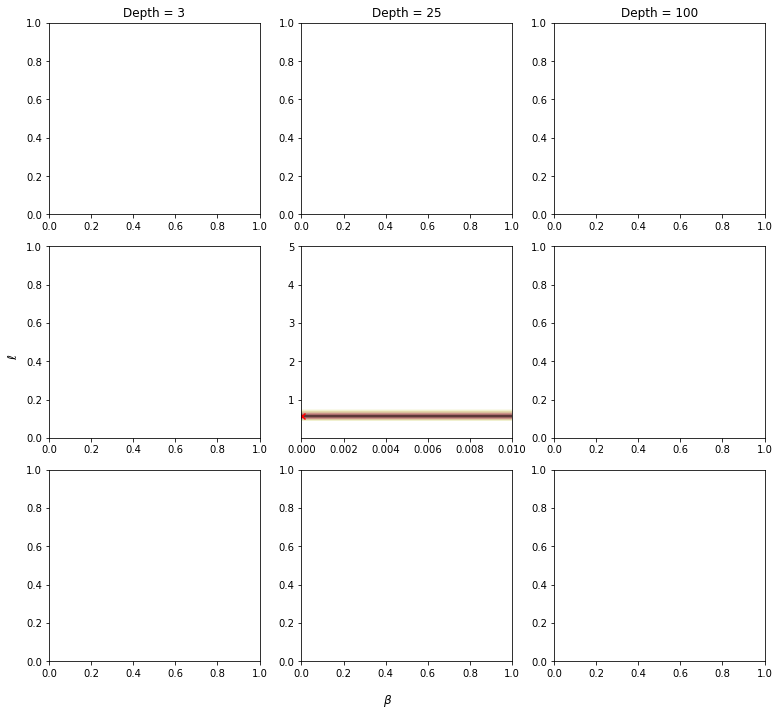

In [47]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(11,10))
ax = ax.ravel()
ax[0].set_title('Depth = 3')
ax[1].set_title('Depth = 25')
ax[2].set_title('Depth = 100')
fig.supxlabel(r'$\beta$')
fig.supylabel(r'$\ell$')
fig.tight_layout()

cmap = 'pink'
color = 'red'
levels = 100
alpha = 1
mesh=500

norm = plt.Normalize(0, 0.1)
optimum = [depth_3.x, depth_25.x, depth_100.x]

lpk = Matern(nu=0.5)

bias = np.linspace(0, 0.01, mesh)
lengthscale = np.linspace(0.0001, 5, mesh)
lengthscale_grid, bias_grid = np.meshgrid(lengthscale, bias)

ntk = NTK(depth=25, c=2.0)
vals = []
for b in bias:
    ntk.bias = b 
    ntk_val = ntk(x1, y1)
    for ell in lengthscale:
        lpk.length_scale = ell
        lpk_val = lpk(x1, y1)

        vals.append(np.abs(lpk_val - ntk_val).squeeze())

vals = np.array(vals).reshape(-1, mesh)



ntk.bias = depth_25.x[0]
lpk.length_scale = depth_25.x[1]

ntk_val_1 = ntk(x1,y1)
ntk_val_2 = ntk(x2,y2)

lpk_val_1 = lpk(x1,y1)
lpk_val_2 = lpk(x2,y2)

print('minimizer at optimum ', 
    np.var([np.abs(ntk_val_1 - lpk_val_1).squeeze(), np.abs(ntk_val_2 - lpk_val_2).squeeze()]) #+ 
    + np.abs(ntk_val_1 - lpk_val_1).squeeze()
    + np.abs(ntk_val_2 - lpk_val_2).squeeze()
)
print('minimizer var term   ', np.var([np.abs(ntk_val_1 - lpk_val_1).squeeze(), np.abs(ntk_val_2 - lpk_val_2).squeeze()]))
print('minimizer d1 term    ', np.abs(ntk_val_1 - lpk_val_1).squeeze())
print('minimizer d2 term    ', np.abs(ntk_val_2 - lpk_val_2).squeeze())
print('value at optimum     ', np.abs(lpk_val_1 - ntk_val_1).squeeze())
print('ell  ', depth_25.x[1])
print('bias ', depth_25.x[0])


print()


i, j = np.where(vals == np.min(vals))
ntk.bias = bias_grid[i, j]
lpk.length_scale = lengthscale_grid[i, j]

ntk_val_1 = ntk(x1,y1)
ntk_val_2 = ntk(x2,y2)

lpk_val_1 = lpk(x1,y1)
lpk_val_2 = lpk(x2,y2)

print('minimizer at plot min', 
    np.var([np.abs(ntk_val_1 - lpk_val_1).squeeze(), np.abs(ntk_val_2 - lpk_val_2).squeeze()]) #+ 
    + np.abs(ntk_val_1 - lpk_val_1).squeeze()
    + np.abs(ntk_val_2 - lpk_val_2).squeeze()
)
print('minimizer var term   ', np.var([np.abs(ntk_val_1 - lpk_val_1).squeeze(), np.abs(ntk_val_2 - lpk_val_2).squeeze()]))
print('minimizer d1 term    ', np.abs(ntk_val_1 - lpk_val_1).squeeze())
print('minimizer d2 term    ', np.abs(ntk_val_2 - lpk_val_2).squeeze())
print('value at plot min    ', np.abs(lpk_val_1 - ntk_val_1).squeeze())
print('ell  ', lengthscale_grid[i, j].squeeze())
print('bias ', bias_grid[i, j].squeeze())




ax[4].contourf(bias_grid, lengthscale_grid, vals, levels, cmap=cmap, norm=norm)
ax[4].scatter(depth_25.x[0], depth_25.x[1], marker='x', color=color)





# for i in range(0,3):
#     if out[i][3] < 10:
#         ellmax = 10
#         biasmax = 7
#         # i=0
#     elif out[i][3] >= 10 and out[i][3] < 30:
#         ellmax = 5
#         biasmax = 0.01
#         # i=1
#     elif out[i][3] >= 30:
#         ellmax = 2.5
#         biasmax = 0.001
#         # i=2

#     bias = np.linspace(0, biasmax, mesh)
#     lengthscale = np.linspace(0.0001, ellmax, mesh)
#     lengthscale_grid, bias_grid = np.meshgrid(lengthscale, bias)


#     ax[i].contourf(bias_grid, lengthscale_grid, np.abs(out[i][0]), levels, cmap=cmap, norm=norm)
#     ax[i].scatter(optimum[i][0], optimum[i][1], marker='x', color=color)

#     ax[3 + i].contourf(bias_grid, lengthscale_grid, np.abs(out[i][1]), levels, cmap=cmap, norm=norm)
#     ax[3 + i].scatter(optimum[i][0], optimum[i][1], marker='x', color=color)

#     if i in (0,1,2):
#         ax[6 + i].contourf(bias_grid, lengthscale_grid, np.abs(out[i][2]), levels, cmap=cmap, norm=norm)
#         ax[6 + i].scatter(optimum[i][0], optimum[i][1], marker='x', color=color)

# cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax.ravel().tolist(), cmap=cmap, ticks=[0, 0.05, 0.1])#, ticks=['0', '0.25', '0.5'])
# cbar.ax.set_yticklabels(['0.00', '0.05', r'$\geq 0.10$']) 

In [ ]:
fig.savefig('heatmap1.svg')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.62it/s]


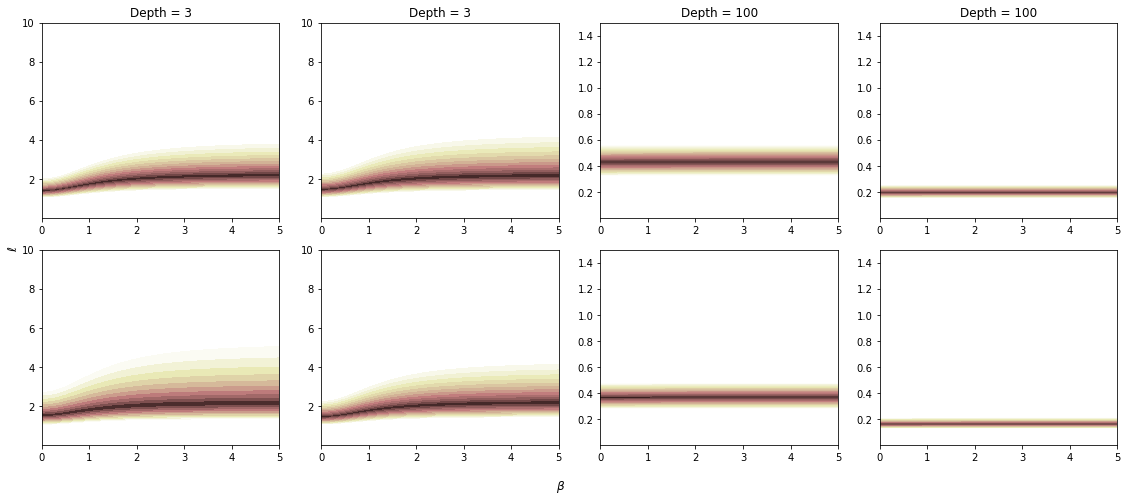

In [36]:
np.random.seed(18935240)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16,7))
ax = ax.ravel()
ax[0].set_title('Depth = 3')
ax[1].set_title('Depth = 3')
ax[2].set_title('Depth = 100')
ax[3].set_title('Depth = 100')
fig.supxlabel(r'$\beta$')
fig.supylabel(r'$\ell$')
fig.tight_layout()

out1 = []
mesh = 2000

colors = 'pink'
levels = 100

norm = plt.Normalize(0, 0.1)

for depth in (3, 100):
    k1 = Matern(nu=0.5)
    k2 = NTK(depth=depth, c=2.0)

    if depth < 10:
        ellmax = 10
        i=0
    elif depth >= 10 and depth < 30:
        ellmax = 5
        i=1
    elif depth >= 30:
        ellmax = 1.5
        i=2

    bias = np.linspace(0, 5, mesh)
    lengthscale = np.linspace(0.0001, ellmax, mesh)
    lengthscale_grid, bias_grid = np.meshgrid(lengthscale, bias)

    x1, y1 = xvals[i][0].get('xy')[0][0]
    x2, y2 = xvals[i][0].get('xy')[0][1]
    x3, y3 = xvals[i][1].get('xy')[0][0]
    x4, y4 = xvals[i][1].get('xy')[0][1]
    # print(xvals_vars[i][2][0][0][0])
    # print(xr,yr)

    vals = []
    for b in tqdm(bias):
        k2.bias = b
        ntk_val = k2(x1,y1)
        for ell in lengthscale:
            k1.length_scale = ell
            lpk_val = k1(x1,y1)

            vals.append(np.abs((lpk_val-ntk_val).squeeze()))
    
    arr = np.array(vals).reshape(-1,mesh)
    ax[0+i].contourf(bias_grid, lengthscale_grid, arr, levels, cmap=colors, norm=norm)

    vals = []
    for b in tqdm(bias):
        k2.bias = b
        ntk_val = k2(x2,y2)
        for ell in lengthscale:
            k1.length_scale = ell
            lpk_val = k1(x2,y2)

            vals.append(np.abs((lpk_val-ntk_val).squeeze()))
    
    arr = np.array(vals).reshape(-1,mesh)
    ax[4+i].contourf(bias_grid, lengthscale_grid, arr, levels, cmap=colors, norm=norm)

    vals = []
    for b in tqdm(bias):
        k2.bias = b
        ntk_val = k2(x3,y3)
        for ell in lengthscale:
            k1.length_scale = ell
            lpk_val = k1(x3,y3)

            vals.append(np.abs((lpk_val-ntk_val).squeeze()))
    
    arr = np.array(vals).reshape(-1,mesh)
    ax[1+i].contourf(bias_grid, lengthscale_grid, arr, levels, cmap=colors, norm=norm)

    vals = []
    for b in tqdm(bias):
        k2.bias = b
        ntk_val = k2(x4,y4)
        for ell in lengthscale:
            k1.length_scale = ell
            lpk_val = k1(x4,y4)

            vals.append(np.abs((lpk_val-ntk_val).squeeze()))
    
    arr = np.array(vals).reshape(-1,mesh)
    ax[5+i].contourf(bias_grid, lengthscale_grid, arr, levels, cmap=colors, norm=norm)

In [37]:
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colors), ax=ax.ravel().tolist(), cmap=colors, ticks=[0, 0.05, 0.1])#, ticks=['0', '0.25', '0.5'])
# cbar.ax.set_yticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', r'$\geq 0.5$'])  # vertically oriented colorbar
cbar.ax.set_yticklabels(['0.00', '0.05', r'$\geq 0.10$']) 

[Text(1, 0.0, '0.00'), Text(1, 5e-02, '0.05'), Text(1, 0.1, '$\\geq 0.10$')]

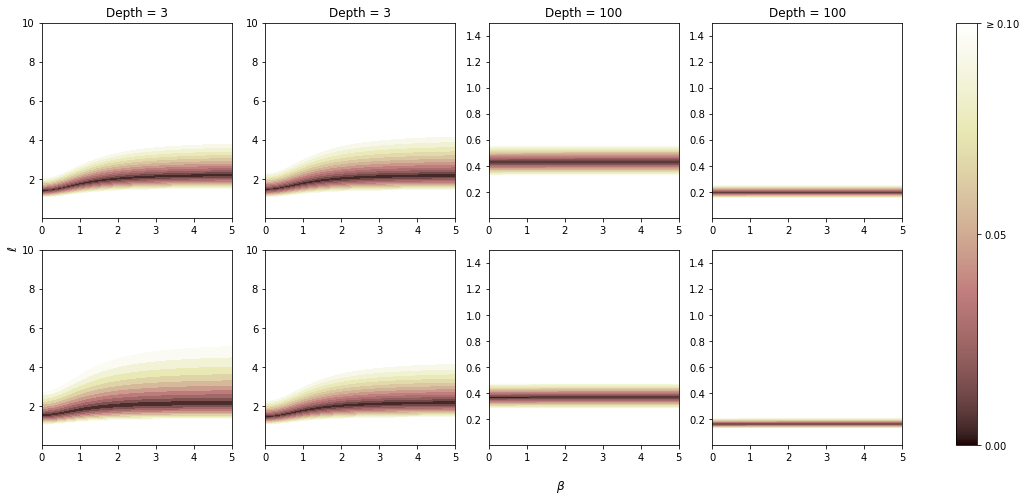

Bad pipe message: %s [b'\x11\xf3KS_BR\xb4\xb5\x91\xf6SJ\x90\xb9h\x0c, \xb0_\x80\x9e\x05\xf0T)U\xecv\xf4\xb1\x85\x9e}P\x8c\xb1\xde\xc1k\xdf0\xe6\xd3s\x90\xbeH\xbe\xe0\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c']
Bad pipe message: %s [b'\x05\x03\x06', b'\x07\x08']
Bad pipe message: %s [b"\xc5\xf4\n\x0cQ\x02\xb6kP*\xd1e\xa9\x11\xe6\xf9\xd2\xb0 \x83\x8c\xaa\x9b\xda5\x124\xe7\xac\x12\xddx\xd9\xcb'\xc9\x06\xe6'\xec\xd0\xbcT\xea\xf5\xcb{\\l10\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04

In [40]:
fig.savefig('heatmap2x2x2.svg')
fig